In [2]:
#!pip3 install -r requirements.txt

In [2]:
sys.path.insert(0, os.getcwd()+"/Data")
sys.path.insert(0, os.getcwd()+"/models")

In [13]:
import sys
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imshow
import Unet2D
import getNucleusSegmentationData
from img_utils import generate_subimages
from keras.models import Model, load_model

## All model variables are defined here

In [10]:
model_inputs = {
      "layer_count": 5,
      "starting_filter_count": 16,
      "convolution_dict": {
         "kernel_initializer": "he_normal",
         "activation": "relu",
         "kernel_size": (3, 3),
         "padding": "same",
        },
      "dropout_weight": 0.2,
      "pooling_dims": (2, 2),
      "stride_dims": (2, 2),
      "output_activation": "sigmoid",
      "image_height": 128,
      "image_width": 128,
      "input_channels": 1,
      "categories": 1,
      "model_optimizer": "adam",
      "loss_function": "binary_crossentropy",
      "validation_split": 0.1,
      "epochs": 10,
      "batch_size": 16,
      "filename": 'Unet-trained-model.h5',
      "stop_after": 5
    }

## Get Training Image Data

In [40]:
this_path = os.getcwd();
x_train, y_train, x_test = getNucleusSegmentationData.getData(model_inputs,this_path)

Loking for file /home/andrew/ImageSegmentationData/NucleusData/data-science-bowl-2018.zip
Train Path is /home/andrew/ImageSegmentationData/NucleusData/data-science-bowl-2018/input/stage1_train/
Getting and resizing train images and masks ... 


100%|██████████| 670/670 [01:15<00:00,  8.92it/s]

Getting and resizing test images ... 



100%|██████████| 65/65 [00:00<00:00, 144.86it/s]

Done!


## Define and Train Model

In [41]:
model = Unet2D.definemodel(model_inputs)

In [5]:
#model.summary()

In [42]:
model, results = Unet2D.trainmodel(x_train, y_train, model, model_inputs)

Train on 603 samples, validate on 67 samples
Epoch 1/10
603/603 [==============================] - 34s 57ms/step - loss: 2.9180 - val_loss: 2.2190

Epoch 00001: val_loss improved from inf to 2.21898, saving model to Unet-trained-model.h5
Epoch 2/10
603/603 [==============================] - 31s 51ms/step - loss: 1.8260 - val_loss: 0.4769

Epoch 00002: val_loss improved from 2.21898 to 0.47690, saving model to Unet-trained-model.h5
Epoch 3/10
603/603 [==============================] - 30s 51ms/step - loss: 0.3561 - val_loss: 0.3006

Epoch 00003: val_loss improved from 0.47690 to 0.30062, saving model to Unet-trained-model.h5
Epoch 4/10
603/603 [==============================] - 30s 50ms/step - loss: 0.2951 - val_loss: 0.2855

Epoch 00004: val_loss improved from 0.30062 to 0.28551, saving model to Unet-trained-model.h5
Epoch 5/10
603/603 [==============================] - 31s 51ms/step - loss: 0.2796 - val_loss: 0.2700

Epoch 00005: val_loss improved from 0.28551 to 0.26997, saving model

## Get Unlabeled Test Data

In [6]:
help(generate_subimages)
x_test = generate_subimages('sem_image.PNG',128,20)

Help on function generate_subimages in module img_utils:

generate_subimages(img_path, sub_size, overlap)
    Produces an array of subimages from a large grayscale image
    
    Parameters
    ----------
    img_path : str, full path to image to be segmented ('/path/to/img.png')
    sub_size : int, Width and height of subimage in pixels (subimages are square)
    overlap  : int, Overlap between adjacent subimages in pixels

(1569, 1815)


## Make predictions on test data based on best model

In [11]:
best_model = load_model(model_inputs['filename'])
predict = best_model.predict(x_test)

In [216]:
### Generate predicted image for quantification

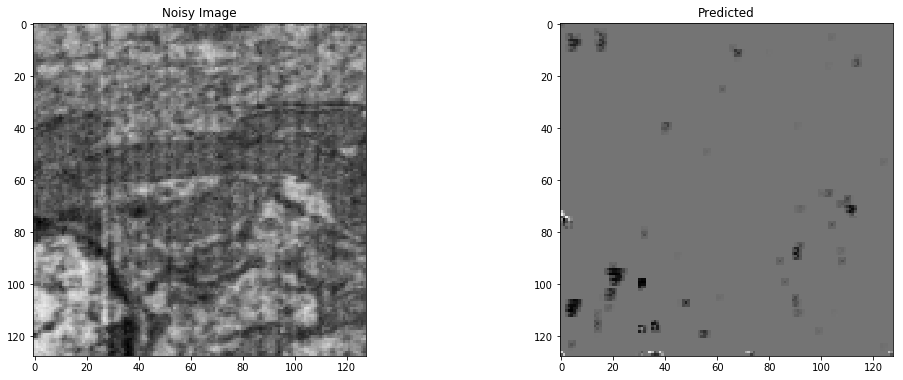

In [17]:
idx =  random.randint(0,x_test.shape[0])
plt.subplot(1,2,1)
imshow(np.squeeze(x_test[idx]))
plt.title('Noisy Image')
plt.subplot(1,2,2)
gray = np.squeeze(predict[idx,:,:])
bw = np.asarray(gray).copy()
# Pixel range is 0...255, 256/2 = 128
bw[bw < 0.5] = 0    # Black
bw[bw >= 0.5] = 1 # White
imshow(gray)
plt.title('Predicted')
#plt.subplot(1,3,3)
#imshow(np.squeeze(y_train[idx,:,:]))
#plt.title('Ground Truth')
fig = plt.gcf()
fig.set_size_inches(15, 5)